# Анализ данных интернет магазина товаров для дома «Пока все ещё тут»

# Описание проекта:
   В нашем распоряжении данные интернет магазина товаров для дома "Пока все еще тут"

# Цель:

Сегментировать покупателей по профилю потребления для создания рассылок

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np 
import datetime as dt
from datetime import datetime, timedelta
import math
import scipy.stats as stats
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.graph_objs import Scatter, Figure, Layout
import plotly
import plotly.graph_objs as go
import plotly.express as px

In [2]:
data = pd.read_csv('/datasets/ecom_dataset_upd.csv')

## Предобработка данных

In [3]:
data.head(5)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


- Приведем дату у корректному формату

In [5]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         7474 non-null   datetime64[ns]
 1   customer_id  7474 non-null   object        
 2   order_id     7474 non-null   int64         
 3   product      7474 non-null   object        
 4   quantity     7474 non-null   int64         
 5   price        7474 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 350.5+ KB


- Приведем товары к нижнему регистру

In [7]:
data['product'] = data['product'].str.lower()

- Проверим дубликаты

In [8]:
data.duplicated().sum()

0

In [9]:
data.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

- Проверим на скрытые дубликаты

In [10]:
data[['customer_id', 'order_id', 'product']].duplicated().sum() 

1886

In [11]:
#удалим скрытые дубликаты
data = data.drop_duplicates(subset = ['customer_id', 'order_id', 'product'])

In [12]:
data[['customer_id', 'order_id', 'product']].duplicated().sum() 

0

### Неявные дубликаты 1 заказ - 1 клиент и 1 заказ - 1 дата

- 1 заказ - 1 клиент

In [13]:
dublicates_order = data.groupby('order_id').agg({'customer_id':'nunique'}).query('customer_id > 1')
display(dublicates_order.head(5))
print('Количество уникальных заказов с различными клиентскими id:', dublicates_order.shape[0])

,customer_id
order_id,
14872,2
68785,2
69283,2
69310,2
69345,2


Количество уникальных заказов с различными клиентскими id: 29


Данных не так много, скорее всего это ошибка выгрузки, удалим их.

In [14]:
list_of_order_id = dublicates_order.index.tolist()
data = data.query('order_id not in @list_of_order_id')

- 1 заказ - одна дата

In [15]:
dublicates_date = data.groupby('order_id').agg({'date':'nunique'}).query('date > 1')
display(dublicates_date.head(5))
print('Количество уникальных заказов с различными датами:', dublicates_date.shape[0])

,date
order_id,
14500,2
14649,2
14898,2
69527,2
69750,2


Количество уникальных заказов с различными датами: 12


- Посмотрим на заказ поближе

In [16]:
data[data['order_id'] == 14898]

,date,customer_id,order_id,product,quantity,price
5762,2019-07-09 22:00:00,3ebc0246-48a6-4932-a759-f492c4a7d879,14898,рассада зелени для кухни душица-орегано розовы...,1,89.0
5763,2019-07-09 22:00:00,3ebc0246-48a6-4932-a759-f492c4a7d879,14898,рассада зелени для кухни иссоп лекарственный а...,1,188.0
5764,2019-07-09 22:00:00,3ebc0246-48a6-4932-a759-f492c4a7d879,14898,рассада зелени для кухни петрушка корневая сах...,1,128.0
5765,2019-07-09 22:00:00,3ebc0246-48a6-4932-a759-f492c4a7d879,14898,рассада зелени для кухни тимьян сильвер квин д...,1,120.0
5766,2019-07-09 22:00:00,3ebc0246-48a6-4932-a759-f492c4a7d879,14898,рассада пряной травы лавр в горшке 9 см,1,45.0
5767,2019-07-09 22:00:00,3ebc0246-48a6-4932-a759-f492c4a7d879,14898,рассада пряной травы эвкалипт сильвердроп в го...,1,52.0
5803,2019-07-10 11:00:00,3ebc0246-48a6-4932-a759-f492c4a7d879,14898,рассада зелени для кухни розмарина в горшке ди...,1,120.0


С данными заказами все в порядке.

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5522 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5522 non-null   datetime64[ns]
 1   customer_id  5522 non-null   object        
 2   order_id     5522 non-null   int64         
 3   product      5522 non-null   object        
 4   quantity     5522 non-null   int64         
 5   price        5522 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 302.0+ KB


# Вывод:
    - Выгрузили данные;
    - Привели формат даты к корректному;
    - Привели названия товаров к нижнему регистру;
    - Проверили данные на явные, скрытые и неявные дубликаты;
    - Удалили дубликаты;
   

## Исследовательский анализ данных

- Посмотрим за какой период предоставлены данные

In [18]:
print('Начало периода:', data['date'].min())
print('Конец периода:', data['date'].max())

Начало периода: 2018-10-01 00:00:00
Конец периода: 2020-01-31 15:00:00


- Добавим столбцы месяц и день покупки

In [19]:
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.weekday
data['year'] = data['date'].dt.year

- Посчитаем количество уникальных заказов по дням месяца и постоим зависимость

In [20]:
orders_per_date = data.groupby('day').agg({'order_id':'nunique'})

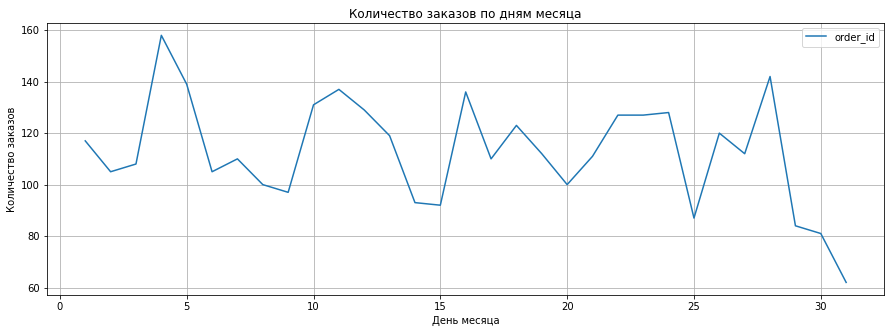

In [21]:
orders_per_date.plot(grid=True, figsize=(15,5))
plt.title('Количество заказов по дням месяца')
plt.xlabel('День месяца')
plt.ylabel('Количество заказов')
plt.show()

Пик заказов приходится на 4е число месяца.

- Сделаем то же самое с месяцами, сделаем разбивку по годам.

In [22]:
data['month_year'] = data['date'].dt.to_period('M').astype(str)

In [23]:
orders_per_month = data.groupby('month_year').agg({'order_id':'nunique'})

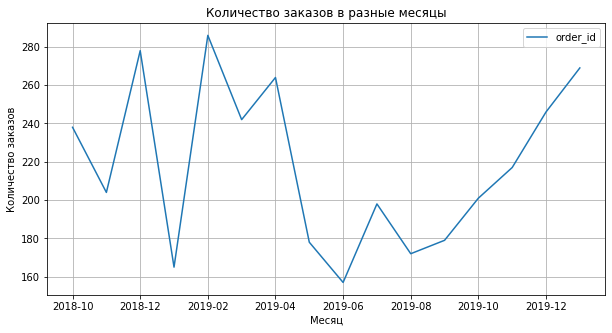

In [24]:
orders_per_month.plot(grid=True, figsize=(10,5)) 
plt.title('Количество заказов в разные месяцы')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Вывод: 
- Виден рост заказов к Новому году
- Рост с Февраля 2019 по Апрель 2019 проихсодит скорее всего из-за сезонности
- С Августа 2019 виден рост до конца года.

- Теперь посмотрим на количество заказов по дням недели

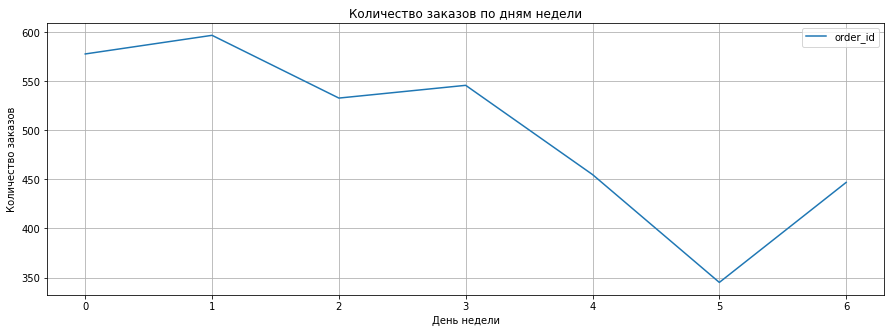

In [25]:
orders_per_weekday = data.groupby('weekday').agg({'order_id':'nunique'})
orders_per_weekday.plot(grid=True, figsize=(15,5)) 
plt.title('Количество заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.show()

По графику видно, что большинство заказов происходнят в будни

- Посмотрим сколько у нас всего уникальных заказов

In [26]:
data['order_id'].nunique()

3492

- Посмотрим сколько у нас всего уникальных пользователей

In [27]:
data['customer_id'].nunique()

2413

- Посмотрим сколько всего товара было продано за период

In [28]:
data['quantity'].sum()

14233

- Добавим столбец с ценой за количество товара в заказе и посчиаем сумму всех проданных товаров

In [29]:
data['total'] = data['quantity'] * data['price']
round(data['total'].sum(),2)

4589736.42

- Посчитаем сумму каждого заказа

In [30]:
total_per_order = data.groupby('order_id').agg({'total':'sum'})
total_per_order

,total
order_id,
12624,375.0
13547,684.0
14480,359.0
14481,600.0
14482,376.0
...,...
112722,450.0
112732,90.0
112767,38.0


- Узнаем значения

In [31]:
total_per_order.describe()

,total
count,3492.000000
mean,1314.357508
std,11592.972525
min,9.000000
25%,194.000000
50%,581.000000
75%,1253.000000
max,675000.000000


Очень странное значение максимум, посмотрим ближе

In [32]:
total_per_order[total_per_order['total'] > 600000]

,total
order_id,
71743,675000.0


In [33]:
data[data['order_id'] == 71743]

,date,customer_id,order_id,product,quantity,price,month,day,weekday,year,month_year,total
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.0,6,18,1,2019,2019-06,675000.0


Получается, что самый дорогой товар, это вантуз.
Удалим его.

In [34]:
data = data.drop([5456],axis = 0)
total_per_order = total_per_order.drop([71743],axis = 0)
total_per_order.describe()

,total
count,3491.000000
mean,1121.379667
std,2086.772191
min,9.000000
25%,194.000000
50%,580.000000
75%,1247.833333
max,49432.000000


- Построим гистограмму

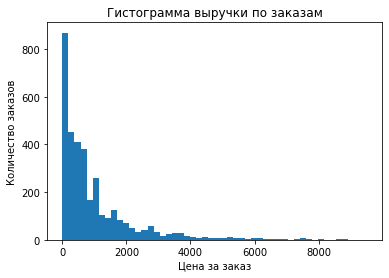

In [35]:
plt.hist(total_per_order['total'], bins = 50, range = (0,9500))
plt.title('Гистограмма выручки по заказам')
plt.xlabel('Цена за заказ')
plt.ylabel('Количество заказов')
plt.show()

На графике видно, что основная часть заказов до 300у.е, большая часть заказов находится в сегменте до 2000$

In [36]:
data.columns.tolist()

['date',
 'customer_id',
 'order_id',
 'product',
 'quantity',
 'price',
 'month',
 'day',
 'weekday',
 'year',
 'month_year',
 'total']

- Присоединим получившиеся данные к таблице

In [37]:
data = data.merge(total_per_order, how='outer', on='order_id')
data.columns = ['date',
 'customer_id',
 'order_id',
 'product',
 'quantity',
 'price',
 'month',
 'day',
 'weekday',
 'year',
 'month_year',
 'total_price',               
 'total_per_order']
data.head(5)

,date,customer_id,order_id,product,quantity,price,month,day,weekday,year,month_year,total_price,total_per_order
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,10,1,0,2018,2018-10,142.0,1037.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,10,1,0,2018,2018-10,194.0,1037.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,10,1,0,2018,2018-10,112.0,1037.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,10,1,0,2018,2018-10,179.0,1037.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,10,1,0,2018,2018-10,112.0,1037.0


- Сведем информацию о клиенте - общая сумма покупок, количество купленных товаров  количество заказов.

In [38]:
info_customer = data.groupby('customer_id').agg({'total_price':'sum', 'quantity':'sum', 'order_id':'nunique'})
info_customer.head(5)

,total_price,quantity,order_id
customer_id,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,555.0,4,1
001cee7f-0b29-4716-b202-0042213ab038,442.0,1,1
00299f34-5385-4d13-9aea-c80b81658e1b,914.0,2,1
002d4d3a-4a59-406b-86ec-c3314357e498,1649.0,1,1
003bbd39-0000-41ff-b7f9-2ddaec152037,2324.0,2,1


- Посчитаем средний чек для каждого клиента

In [39]:
avg_per_customer = data.groupby(['customer_id', 'order_id']).agg({'total_per_order':'sum'})
avg_per_customer_1 = data.groupby('customer_id').agg({'total_per_order':'mean'})
avg_per_customer_1.head(5)

,total_per_order
customer_id,
000d6849-084e-4d9f-ac03-37174eaf60c4,555.0
001cee7f-0b29-4716-b202-0042213ab038,442.0
00299f34-5385-4d13-9aea-c80b81658e1b,914.0
002d4d3a-4a59-406b-86ec-c3314357e498,1649.0
003bbd39-0000-41ff-b7f9-2ddaec152037,2324.0


- Посмотрим средние, минимальные и максимальные значения по среднему чеку клиентов

In [40]:
avg_per_customer_1.describe()

,total_per_order
count,2412.000000
mean,1172.932503
std,2108.884550
min,15.000000
25%,300.000000
50%,652.000000
75%,1349.000000
max,49432.000000


Максимальный чек составил 49432, минимальный 15, в среднем клиенты покупают на сумму 1173

- Посмотрим на средние, минимальные и максимальные значения по суммарным тратам клиентов и построим гистограмму

In [41]:
info_customer['total_price'].describe()

count      2412.000000
mean       1623.025048
std        4341.333501
min          15.000000
25%         389.000000
50%         837.000000
75%        1798.250000
max      159508.000000
Name: total_price, dtype: float64

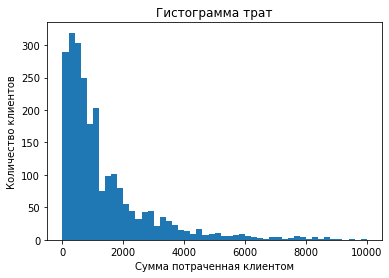

In [42]:
plt.hist(info_customer['total_price'], bins = 50, range = (0,10000))
plt.title('Гистограмма трат')
plt.xlabel('Сумма потраченная клиентом')
plt.ylabel('Количество клиентов')
plt.show()

В среднем клиенты тратят 1624, минимально 15, максимум 159508

- Посмотрим на минимальные, максимальные и средние значения по количеству купленных товаров

In [43]:
info_customer['quantity'].describe()

count    2412.000000
mean        5.486318
std        18.077424
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max       334.000000
Name: quantity, dtype: float64

- Посмотрим на минимальные, максимальные и средние значения по количеству заказов

In [44]:
info_customer['order_id'].describe()

count    2412.000000
mean        1.447347
std         2.698627
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       126.000000
Name: order_id, dtype: float64

Минимтально клиенты делают 1 заказ с одним товаром, максимально 126 заказов с 334 товарами, в среднем за период было куплено 5-6 товаров и большинство клиентов сделали 1-2 заказа.

Для интереса взглянем на клиента потратившего больше всего денег.

In [45]:
info_customer[info_customer['total_price'] > 60000]

,total_price,quantity,order_id
customer_id,,,
c971fb21-d54c-4134-938f-16b62ee86d3b,159508.0,334,126


Логично, что максимальные значения по количеству заказов и количеству товаров соответствуют этому клиенту.

- Присоединим все данные к основной таблице и переименуем столбцы

In [46]:
data.columns.tolist()

['date',
 'customer_id',
 'order_id',
 'product',
 'quantity',
 'price',
 'month',
 'day',
 'weekday',
 'year',
 'month_year',
 'total_price',
 'total_per_order']

In [47]:
data = data.merge(info_customer, how='outer', on='customer_id')
data = data.merge(avg_per_customer_1, how='outer', on='customer_id')
data.columns = ['date',
 'customer_id',
 'order_id',
 'product',
 'quantity',
 'price',
 'month',
 'day',
 'weekday',                   
 'total_price',
 'year',
 'month_year',               
 'total_per_order',
 'total_per_customer',
 'products_per_customer',             
 'orders_per_customer',
 'avg_customer_receipt']
data.head(5)

,date,customer_id,order_id,product,quantity,price,month,day,weekday,total_price,year,month_year,total_per_order,total_per_customer,products_per_customer,orders_per_customer,avg_customer_receipt
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,10,1,0,2018,2018-10,142.0,1037.0,1037.0,7,1,1037.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,10,1,0,2018,2018-10,194.0,1037.0,1037.0,7,1,1037.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,10,1,0,2018,2018-10,112.0,1037.0,1037.0,7,1,1037.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,10,1,0,2018,2018-10,179.0,1037.0,1037.0,7,1,1037.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,10,1,0,2018,2018-10,112.0,1037.0,1037.0,7,1,1037.0


# Вывод:

- Данные предоставлены за период с 01.10.2018 по 31.01.2020;
- Разбивка по месяцам за весь период.
        - Виден рост заказов к Новому году
        - Рост с Февраля 2019 по Апрель 2019 проихсодит скорее всего из-за сезонности
        - С Августа 2019 виден рост до конца года.
- Большинство заказов происходят в будни;
- Всего у нас 3492 эникальных заказа и 2413 уникальных пользователя;
- За период было продано 14233 товара;
- Основная часть заказов до 300у.е, большая часть заказов находится в сегменте до 2000у.е;
- Максимальный чек составил 49432, минимальный 15, в среднем клиенты покупают на сумму 1173;
- В среднем клиенты тратят 1624, минимально 15, максимум 159508;
- Минимтально клиенты делают 1 заказ с одним товаром, максимально 126 заказов с 334 товарами, в среднем за период было куплено 5-6 товаров и большинство клиентов сделали 1-2 заказа;

## Сегментирование покупателей по профилю потребления.


Для RFM-анализа нам нужны: id клиента, id заказа, дата заказа, количество покупок и итоговая сумма покупок.

In [48]:
NOW = dt.datetime(2020,1,31)
# Создаём таблицу RFM
RFM_table = data.groupby('customer_id').agg({'date': lambda x: (NOW - x.max()).days, # Recency
                                                'order_id': lambda x: len(x.unique()), # Frequency
                                                'total_price': lambda x: x.sum()})    # Monetary 

RFM_table['date'] = RFM_table['date'].astype(int)

RFM_table.rename(columns={'date': 'recency', 
                         'order_id': 'frequency',
                         'total_price': 'monetary_value'}, inplace=True)
RFM_table.head(10)

,recency,frequency,monetary_value
customer_id,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,106,1,8076
001cee7f-0b29-4716-b202-0042213ab038,348,1,2019
00299f34-5385-4d13-9aea-c80b81658e1b,108,1,2019
002d4d3a-4a59-406b-86ec-c3314357e498,368,1,2019
003bbd39-0000-41ff-b7f9-2ddaec152037,123,1,2019
004d24e9-4a6c-4d0e-8727-8391dfd4b43a,368,1,2019
005ba170-45e8-42de-93f7-192481ae2659,86,2,4037
00bd74b1-2792-47db-a2f1-680a09ac5026,466,1,2018
00c0f92a-121a-4883-a78d-2c7b5fe187de,49,2,4038


- Распределим на 3 квинтиля

In [49]:
quantiles = RFM_table.quantile(q=[0.33,0.66,0.99])
quantiles

,recency,frequency,monetary_value
0.33,103.00,1.0,2019.0
0.66,298.00,2.0,4038.0
0.99,482.89,3.0,36342.0


- Конвертируем инфорацию в словарь

In [50]:
quantiles = quantiles.to_dict()

- 
Делаем копию таблицы

In [51]:
RFM_Segment = RFM_table.copy()

- Присваиваем каждому клиенту свою группу давности, частоты и суммы покупок

In [52]:
def R_Class(x,p,d):
    if x <= d[p][0.33]:
        return 3
    elif x <= d[p][0.66]:
        return 2
    else:
        return 1
    
def FM_Class(x,p,d):
    if x <= d[p][0.33]:
        return 1
    elif x <= d[p][0.66]:
        return 2
    else:
        return 3

- Добавляем группы в итоговую таблицу и считаем RFM показатель для каждого клиента

In [53]:
RFM_Segment['R_Quartile'] = RFM_Segment['recency'].apply(R_Class, args=('recency',quantiles,))
RFM_Segment['F_Quartile'] = RFM_Segment['frequency'].apply(FM_Class, args=('frequency',quantiles,))
RFM_Segment['M_Quartile'] = RFM_Segment['monetary_value'].apply(FM_Class, args=('monetary_value',quantiles,))
RFM_Segment['RFMClass'] = RFM_Segment.R_Quartile.map(str) \
                            + RFM_Segment.F_Quartile.map(str) \
                            + RFM_Segment.M_Quartile.map(str)

In [54]:
RFM_Segment.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,106,1,8076,2,1,3,213
001cee7f-0b29-4716-b202-0042213ab038,348,1,2019,1,1,1,111
00299f34-5385-4d13-9aea-c80b81658e1b,108,1,2019,2,1,1,211
002d4d3a-4a59-406b-86ec-c3314357e498,368,1,2019,1,1,1,111
003bbd39-0000-41ff-b7f9-2ddaec152037,123,1,2019,2,1,1,211


### Присвоенные значения:

#### Давность заказа (recency)
 - 1 - давно
 - 2 - относительно недавно
 - 3 - недавно
#### Частота покупок (frequency):
 - 1 - редко
 - 2 - нечасто
 - 3 - часто
#### Сумма покупок (monetary):
 - 1 - маленькая сумма
 - 2 - средняя сумма
 - 3 - большая сумма

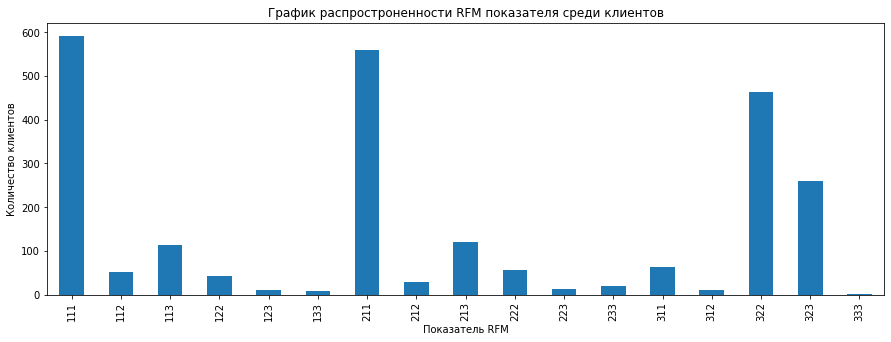

In [55]:
fig=plt.figure(figsize=(15, 5)), 
RFM_Segment.groupby('RFMClass').agg('recency').count().plot(kind='bar')
plt.title('График распростроненности RFM показателя среди клиентов')
plt.xlabel('Показатель RFM')
plt.ylabel('Количество клиентов')
plt.show()

# Вывод:

Из графика выше выделим 3 категории:

1. 133, 213, 222, 223, 233, 313, 323, 333 - эти клиенты чаще заходят в магазин и недавно делали покупки, назовем их "Золотые"


2. 113, 122, 123, 212, 221, 232, 321, 322 - эти клиенты покупают на большие и средние суммы, но заходили в магазин давно или редко, назавом их "Постоянные"


2. 111, 112, 121, 131, 211, 231, 311, 312 - эти клиенты заходили в магазин давно, покупают редко и на небольшую сумму, назовем их "Малоактивные"


In [56]:
filter_1 = ['133', '213', '222', '223', '233', '313', '323', '333']
filter_2 = ['113', '122', '123', '212', '221', '232', '321', '322']
filter_3 = ['111', '112', '121', '131', '211', '231', '311', '312']
group_1 = RFM_Segment[RFM_Segment.RFMClass.isin(filter_1)]
group_2 = RFM_Segment[RFM_Segment.RFMClass.isin(filter_2)]
group_3 = RFM_Segment[RFM_Segment.RFMClass.isin(filter_3)]

In [57]:
group_1.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,106,1,8076,2,1,3,213
0184f535-b60a-4914-a982-231e3f615206,252,5,60570,2,3,3,233
01a53da1-c3ae-47cf-916e-7e345fe2f2bc,17,2,4039,3,2,3,323
01bd5b9a-2b4e-483c-95a3-40b040c392e8,248,1,14133,2,1,3,213
02a27adc-a1fe-4aaf-9945-1ab779979537,9,2,4039,3,2,3,323


In [58]:
group_2.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
005ba170-45e8-42de-93f7-192481ae2659,86,2,4037,3,2,2,322
00c0f92a-121a-4883-a78d-2c7b5fe187de,49,2,4038,3,2,2,322
00cd704a-a65c-4865-b39a-779f1b4f1d1a,50,2,4038,3,2,2,322
00ff5327-0fba-481c-8a07-47a95093a213,43,2,4038,3,2,2,322
01c31cf3-cdb3-4b90-a2ef-ebe1b9e1fc33,452,1,6054,1,1,3,113


In [59]:
group_3.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
001cee7f-0b29-4716-b202-0042213ab038,348,1,2019,1,1,1,111
00299f34-5385-4d13-9aea-c80b81658e1b,108,1,2019,2,1,1,211
002d4d3a-4a59-406b-86ec-c3314357e498,368,1,2019,1,1,1,111
003bbd39-0000-41ff-b7f9-2ddaec152037,123,1,2019,2,1,1,211
004d24e9-4a6c-4d0e-8727-8391dfd4b43a,368,1,2019,1,1,1,111


## Разбивка товаров на категории

- Определим уникальные наименования

In [60]:
unique_items = pd.DataFrame(data['product'].unique(), columns = ['product'])
unique_items.sample(10)

,product
43,фиалка микс d-9 см
510,"гладильная доска ника бэлль 106,5х29 см б"
1222,фуксия swingtime белая с красным чашелистом об...
2298,сушилка для белья потолочная zalger lift comfo...
1906,"нож универсальный pro 13 см, attribute, akl113"
795,"кореопсис толл 0,1 г 4650091480258"
1245,корзина для белья эльфпласт виола 30 л коричне...
980,термос 1л svb-1000h
663,муляж виноград желтый 24 см полиуретан
1851,"рассада огурца сорт персей, кассета по 6шт"


In [61]:
data['item'] = data['product'].apply(lambda x: x.split()[:1]).str.join(', ')
data['item'].to_frame().sample(10)

,item
4441,ванна
482,стремянка
2457,гладильная
3205,томата
1126,лапчатка
956,салатник
3130,томата
5324,чехол
4796,сумка-тележка
2275,рассада


In [62]:
data['item'].nunique()

461

- Делим товары на категории:

In [63]:
garden_tools = ['сушилка', 'гладильный', 'сумка', 'доска', 'горшок', 'сушилк', 'тележка', 'хозяйственный',\
               'искусственный', 'чехол', 'стремян', 'алюминиевый', 'черенок', 'кашпо', 'багажный', \
               'ведро', 'контейнер', 'швабра', 'ведро', 'мытье', 'крючок', 'обув', 'перчатк', 'ящик', 'лоток',\
               ]

In [64]:
plants = ['цветок', 'рассада', 'среднеспелый', 'томат', 'помидор', 'диам', 'пеларгония', 'розовый',\
          'зелень', 'роза', 'среднеспелый', 'муляж', 'однолетний', 'пластиковый', 'петуния', 'раннеспелый',\
          'растение', 'огурец', 'герань', 'тимьян', 'цикламен', 'калибрахоа', 'флокс', 'тыква', 'клубника',\
          'петрушка', 'фиалка', 'бегония', 'трава', 'флокс', 'перец', 'душица', 'комнатн', 'фуксия', 'капуста',\
          'дыня', 'хлорофитум', 'хризантема', 'зверобой', 'кореопсис', 'цветущее', 'лавр', 'ель', 'антуриум', 'укроп'\
          'осина', 'бадан', 'антинакипин', 'радермахер', 'хризолидокарпус', 'юкка', 'суккулент', \
          'цинерария', 'диффенбахий', 'эхинокактус', 'гипсофил', 'ранункулус', 'эхинацея', 'мускарь',\
          'горох', 'эхинокактус', 'табак', 'петрушка', 'шеффлер', 'многолетний', 'алиссум', 'бальзам', 'настурция',\
          'адиантум', 'кампануть', 'нолина', 'глоксиния', 'иссоп', 'сантолина', 'мелисса', \
          'космея', 'бархатцы', 'монарда', 'гортензия', 'диффенбахий', 'цинерария', 'шалфей', 'валериана', 'бадан',\
          'агератум', 'аргирантерум', 'вероника', 'целозия', 'сальвия', 'фатсия', 'хоста', 'монард', \
          'настольный', 'альбук', 'артемизия', 'калоцефалус', 'каллун', 'капсикум', 'соланум',\
          'бархатцы', 'годеция', 'эшшольция', 'пуансетия', 'кипарисовик', 'фиттоний', 'кодонант',\
          'калла', 'портулак', 'патиссон', 'эхеверие', 'хризантема', 'лаванда', 'кофе', 'овсянница',\
          'суккулент', 'драцена', 'морковь', 'годеция', 'эшшольция', 'комнатный', 'аптение', 'настурция', 'цветущий',\
          'девичий', 'лантан', 'ель', 'фикус', 'лен', 'лапчатка', 'рудбекия', 'цитрофортунелла', 'подсолнечник']

In [65]:
crockery = ['luminarc', 'тарелк', 'салатник', 'чайник', 'салфетк', 'ложк', 'стакан', 'крышк', 'вилк', 'нож',\
           'сковород', 'кружк', 'термос', 'губка', 'измельчитель', 'миска', 'хлебница', 'сахарн', 'рыбочистка',\
           'соковарка', 'бидон', 'картофелемялка','орехоколка',  'скраб', 'венчик', 'сито',\
           'блюдо','tepмокружка','кухонный','миска','блюдце', \
           'скалка', 'завертка',  'толкушка', 'пружина', 'молодить', 'лопатка', ]

In [66]:
furniture = ['кухня', 'ванный', 'коврик', 'вешалк', 'потолочный', 'ванна', 'обеденн', 'щетк', 'карниз',\
             'таз', 'штора', 'зубн', 'коробк', 'полка', 'комод', 'лестниц', 'щетка', 'щётка', 'увлажнять',\
             'скоба', 'пресс', 'кольцо', 'фоторамка', 'ключница', 'перекладина', 'модульный', 'фал',   \
             'корыто', 'ковер', 'сидение', 'плед', 'полотенце', 'ваза', 'подушка', 'утюг', 'кисточка', 'шило',\
             'этажерка', 'стойка', 'стеллаж', 'нетканый', 'полк', 'моп', 'тряпкодержатель', 'шпагат', 'шприц', 'крышка',\
             'бензин', 'пробка', 'универсальный', 'сменный', 'кисточка', 'сетка', 'ручка', 'складной', 'просеиватель', 'отжим', \
             'вкладыш', 'стиральный', 'чистить', 'светильник', 'жидкий', 'пена', 'ножеточка', 'линейка', 'салфетница', 'овощечистка', \
             'держатель', 'губка', 'антижир', 'ролик', 'картофелемялка', 'ароматизированный', 'бальзам', 'рассекатель', 'ополаскиватель', \
             'скоба', 'пресс', 'кольцо', 'фоторамка', 'ключница', 'перекладина', 'модульный', 'фал', 'орехоколка', 'увлажнять', \
              'концентрат', 'смолевка', 'фиксатор', 'шар', 'обувница', 'штангенциркуль','совок', 'измерительный',\
             'сотейник', 'ванна', 'прищепок', 'отделитель', 'веревка', 'отбеливатель', 'решетка', 'запасный', 'уголок', 'тряпка', \
             'сахарница', 'половник', 'котел', 'готовый',]

In [67]:
other = ['']

In [68]:
def category(row):   
    for i in garden_tools:
        if i in row:
            return "Товары для сада"

    for i in plants:
        if i in row:
            return "Растения"

    for i in crockery:
        if i in row:
            return "Кухонные принадлежности"

    for i in furniture:
        if i in row:
            return "Товары для дома"

    for i in other:
        if i in row:
            return "Другое"

data['category'] = data['product'].str.lower().apply(category)

In [69]:
data.head()

,date,customer_id,order_id,product,quantity,price,month,day,weekday,total_price,year,month_year,total_per_order,total_per_customer,products_per_customer,orders_per_customer,avg_customer_receipt,item,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,10,1,0,2018,2018-10,142.0,1037.0,1037.0,7,1,1037.0,комнатное,Растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,10,1,0,2018,2018-10,194.0,1037.0,1037.0,7,1,1037.0,комнатное,Растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,10,1,0,2018,2018-10,112.0,1037.0,1037.0,7,1,1037.0,радермахера,Растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,10,1,0,2018,2018-10,179.0,1037.0,1037.0,7,1,1037.0,хризолидокарпус,Растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,10,1,0,2018,2018-10,112.0,1037.0,1037.0,7,1,1037.0,циперус,Другое


- Добавим в наши группы столбцы date и category из основного ДФ.

In [70]:
group_1 = pd.merge(group_1,data[['customer_id','category','date']],on='customer_id', how='left')

In [71]:
group_1

,customer_id,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,category,date
0,000d6849-084e-4d9f-ac03-37174eaf60c4,106,1,8076,2,1,3,213,Растения,2019-10-16 08:00:00
1,000d6849-084e-4d9f-ac03-37174eaf60c4,106,1,8076,2,1,3,213,Товары для сада,2019-10-16 08:00:00
2,000d6849-084e-4d9f-ac03-37174eaf60c4,106,1,8076,2,1,3,213,Растения,2019-10-16 08:00:00
3,000d6849-084e-4d9f-ac03-37174eaf60c4,106,1,8076,2,1,3,213,Растения,2019-10-16 08:00:00
4,0184f535-b60a-4914-a982-231e3f615206,252,5,60570,2,3,3,233,Товары для сада,2019-03-07 10:00:00
...,...,...,...,...,...,...,...,...,...,...
2319,ff422162-fc4a-4b65-a0e2-17f5095ea2c6,325,3,6057,1,3,3,133,Товары для сада,2019-03-11 10:00:00
2320,ff422162-fc4a-4b65-a0e2-17f5095ea2c6,325,3,6057,1,3,3,133,Товары для сада,2019-03-11 11:00:00
2321,ff422162-fc4a-4b65-a0e2-17f5095ea2c6,325,3,6057,1,3,3,133,Кухонные принадлежности,2019-03-11 15:00:00
2322,ff601403-b094-4b86-9ac6-264d725b9277,11,2,4039,3,2,3,323,Товары для сада,2019-08-16 16:00:00


In [72]:
group_2 = pd.merge(group_2,data[['customer_id','category','date']],on='customer_id', how='left')

In [73]:
group_2

,customer_id,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,category,date
0,005ba170-45e8-42de-93f7-192481ae2659,86,2,4037,3,2,2,322,Товары для дома,2018-10-30 20:00:00
1,005ba170-45e8-42de-93f7-192481ae2659,86,2,4037,3,2,2,322,Товары для сада,2019-11-05 21:00:00
2,00c0f92a-121a-4883-a78d-2c7b5fe187de,49,2,4038,3,2,2,322,Товары для сада,2019-02-23 16:00:00
3,00c0f92a-121a-4883-a78d-2c7b5fe187de,49,2,4038,3,2,2,322,Растения,2019-12-12 12:00:00
4,00cd704a-a65c-4865-b39a-779f1b4f1d1a,50,2,4038,3,2,2,322,Товары для сада,2019-02-21 08:00:00
...,...,...,...,...,...,...,...,...,...,...
1865,fd81297f-0495-4045-be04-d65061ab5e98,65,2,4038,3,2,2,322,Товары для дома,2019-11-26 20:00:00
1866,fe3e6382-3272-4045-8601-c9acfc08006f,51,2,4038,3,2,2,322,Товары для сада,2019-02-18 14:00:00
1867,fe3e6382-3272-4045-8601-c9acfc08006f,51,2,4038,3,2,2,322,Другое,2019-12-10 10:00:00
1868,fef19457-5e7b-4d5d-b031-806041bc251a,70,2,4037,3,2,2,322,Товары для сада,2018-12-19 14:00:00


In [74]:
group_3 = pd.merge(group_3,data[['customer_id','category','date']],on='customer_id', how='left')

In [75]:
group_3

,customer_id,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,category,date
0,001cee7f-0b29-4716-b202-0042213ab038,348,1,2019,1,1,1,111,Товары для сада,2019-02-16 11:00:00
1,00299f34-5385-4d13-9aea-c80b81658e1b,108,1,2019,2,1,1,211,Другое,2019-10-14 23:00:00
2,002d4d3a-4a59-406b-86ec-c3314357e498,368,1,2019,1,1,1,111,Товары для сада,2019-01-27 17:00:00
3,003bbd39-0000-41ff-b7f9-2ddaec152037,123,1,2019,2,1,1,211,Товары для сада,2019-09-29 17:00:00
4,004d24e9-4a6c-4d0e-8727-8391dfd4b43a,368,1,2019,1,1,1,111,Товары для дома,2019-01-27 12:00:00
...,...,...,...,...,...,...,...,...,...,...
1322,ff0c73c3-6b62-4e67-8e12-bb83ed1851d5,92,1,2019,3,1,1,311,Товары для сада,2019-10-30 19:00:00
1323,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,92,1,2019,3,1,1,311,Товары для дома,2019-10-30 07:00:00
1324,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,412,1,2018,1,1,1,111,Растения,2018-12-14 23:00:00
1325,ffb80538-3fda-4351-8ea9-9d2bec58bb07,143,1,2019,2,1,1,211,Кухонные принадлежности,2019-09-09 12:00:00


In [76]:
group_1['month'] = group_1['date'].dt.month
group_2['month'] = group_2['date'].dt.month

group_1['weekday'] = group_1['date'].dt.weekday
group_2['weekday'] = group_2['date'].dt.weekday

group_1['year'] = group_1['date'].dt.year
group_2['year'] = group_2['date'].dt.year

- Данные разбиваем по годам и смотрим сезонность

In [77]:
group_1['m_y'] = group_1['date'].dt.to_period('M').astype(str)

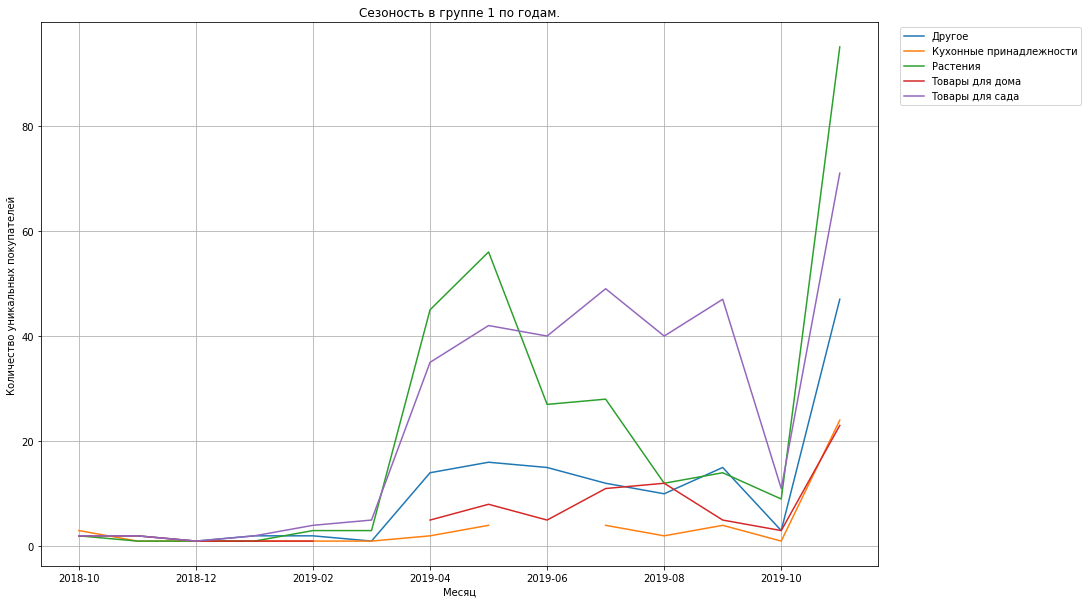

In [78]:
group_1.pivot_table(
    index='m_y',  
    columns='category',  
    values='customer_id',  
    aggfunc='nunique',  
).plot(figsize=(15, 10), grid=True)

plt.title('Сезоность в группе 1 по годам.')
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных покупателей')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='best')
plt.show()

### Группа 1:

 - Лидерами за весь период являются растения и товары для сада
 - Начиная с Марта 2019 категории растения и товары для сада растут (Начинается дачный сезон). На протяжении всего лета эти категории в лидерах.
 - Начиная с октября 2019 до января 2020 все категории показывают рост. 
 - Хуже всего продаются кухонные принадлежности.

In [79]:
group_2['m_y'] = group_2['date'].dt.to_period('M').astype(str)

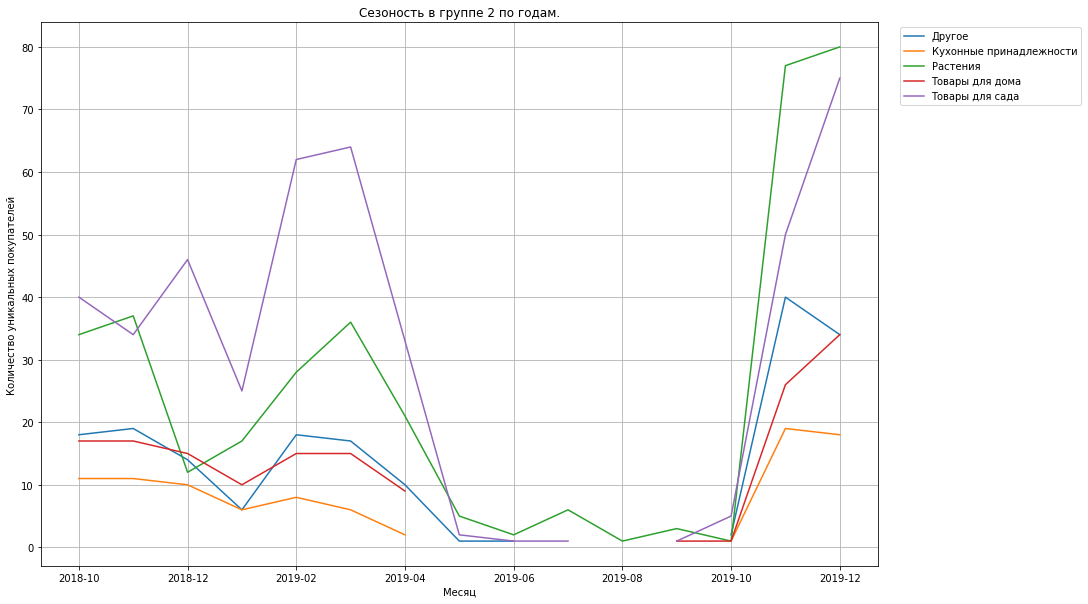

In [80]:
group_2.pivot_table(
    index='m_y',  
    columns='category',  
    values='customer_id',  
    aggfunc='nunique',  
).plot(figsize=(15, 10), grid=True)

plt.title('Сезоность в группе 2 по годам.')
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных покупателей')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='best')
plt.show()

### Группа 2:

- Лидер: Товары для сада и Растерия. 
- Видна сезонность этих товаров в весенне-летние месяцы начиная с Марта и заканчивая Августом. 
- Осенью, начиная с Октября виден рост всех товаров. Лидеры так же товары для сада и растения. (Распродажа)
- В период с Апреля по Июнь наблюдается рост всех категорий.
- Хуже всего продается категория кухонные принадлежности.

In [81]:
group_3['m_y'] = group_3['date'].dt.to_period('M').astype(str)

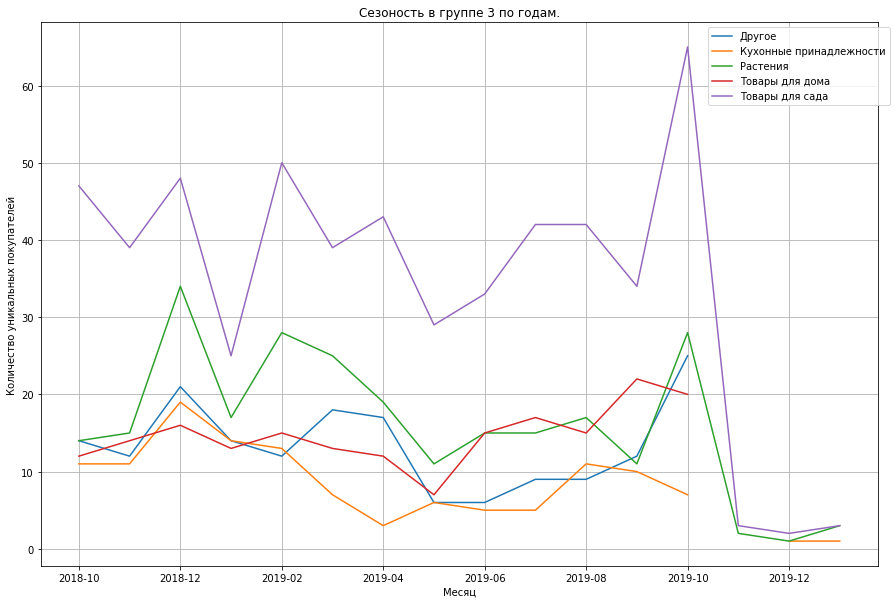

In [82]:
group_3.pivot_table(
    index='m_y',  
    columns='category',  
    values='customer_id',  
    aggfunc='nunique',  
).plot(figsize=(15, 10), grid=True)

plt.title('Сезоность в группе 3 по годам.')
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных покупателей')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='best')
plt.show()

### Группа 3:

- Лидер: Товары для сада и Растерия. 
- Видна сезонность этих товаров в весной и осенью в Ноябре.
- В летние месяцы почти все товары продавались одинаково.
- Виден спад в Ноябре 2019, скорее всего эти клиенты перестали покупать.
- Хуже всего продается категория кухонные принадлежности.

## Проверка гипотез


### Гипотеза о различии количества товаров в группах

- Н0 : Нет различий в количестве купленных товаров между сегментами
- H1:  Есть разница в количестве купленных товаров между сегментами


Уровень значимости: 0,05

Для проверики используем U-тест Манна-Уитни

Добавим столбец с количеством товара для наших групп.

In [83]:
quantity = data.groupby('customer_id').agg({'quantity':'sum'})
group_1 = group_1.merge(quantity, on='customer_id')
group_2 = group_2.merge(quantity, on='customer_id')
group_3 = group_3.merge(quantity, on='customer_id')

In [84]:
alpha = 0.05 

# Проводим тест U-тест Манна-Уитни

bonferroni_alpha = alpha / 3

results_AB = stats.mannwhitneyu(group_1['quantity'], group_2['quantity'])
results_BC = stats.mannwhitneyu(group_2['quantity'], group_3['quantity'])
results_AC = stats.mannwhitneyu(group_1['quantity'], group_3['quantity'])


if results_AB.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп А и B')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B'
    )

if results_BC.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп B и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп B и C'
    )

if results_AC.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп А и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и C'
    ) 

Отвергаем нулевую гипотезу для сравнения групп А и B
Отвергаем нулевую гипотезу для сравнения групп B и C
Отвергаем нулевую гипотезу для сравнения групп А и C


# Вывод: 

 Есть разница в количестве купленных товаров между сегментами

### Гипотеза о различии среднего чека в группах

Сформируем гипотезу:

- Н0 : Нет различий в среднем чеке между сегментами
- H1:  Есть разница в среднем чеке между сегментами

Уровень значимости: 0,05

Для проверики используем U-тест Манна-Уитни

Для проверки гипотезы посчитаем средний чек группы 1, 2, 3

In [85]:
group_1['monetary_value_mean'] = group_1['monetary_value'] / group_1['quantity']
avg_check_group_1 = group_1.groupby('customer_id').agg({'monetary_value_mean': 'mean'})
avg_check_group_1

,monetary_value_mean
customer_id,
000d6849-084e-4d9f-ac03-37174eaf60c4,2019.000000
0184f535-b60a-4914-a982-231e3f615206,1044.310345
01a53da1-c3ae-47cf-916e-7e345fe2f2bc,2019.500000
01bd5b9a-2b4e-483c-95a3-40b040c392e8,1766.625000
02a27adc-a1fe-4aaf-9945-1ab779979537,2019.500000
...,...
fd9e34ca-13c6-486d-bc47-366fbfe488f8,2019.500000
fe2ef13a-4c8f-4cad-9c2d-49b535b5857e,2019.500000
ff31d802-dae6-484d-a3dc-c9723f1cb538,2019.000000


In [86]:
group_2['monetary_value_mean'] = group_2['monetary_value'] / group_2['quantity']
avg_check_group_2 = group_2.groupby('customer_id').agg({'monetary_value_mean': 'mean'})
avg_check_group_2

,monetary_value_mean
customer_id,
005ba170-45e8-42de-93f7-192481ae2659,1345.666667
00c0f92a-121a-4883-a78d-2c7b5fe187de,2019.000000
00cd704a-a65c-4865-b39a-779f1b4f1d1a,2019.000000
00ff5327-0fba-481c-8a07-47a95093a213,2019.000000
01c31cf3-cdb3-4b90-a2ef-ebe1b9e1fc33,2018.000000
...,...
fd003d94-d728-49ca-9b6a-f17a43786d8a,2019.000000
fd723976-e0e0-41bc-9f08-e81436ebfff3,2018.500000
fd81297f-0495-4045-be04-d65061ab5e98,2019.000000


In [87]:
group_3['monetary_value_mean'] = group_3['monetary_value'] / group_3['quantity']
avg_check_group_3 = group_3.groupby('customer_id').agg({'monetary_value_mean': 'mean'})
avg_check_group_3

,monetary_value_mean
customer_id,
001cee7f-0b29-4716-b202-0042213ab038,2019.00
00299f34-5385-4d13-9aea-c80b81658e1b,1009.50
002d4d3a-4a59-406b-86ec-c3314357e498,2019.00
003bbd39-0000-41ff-b7f9-2ddaec152037,1009.50
004d24e9-4a6c-4d0e-8727-8391dfd4b43a,168.25
...,...
ff0c73c3-6b62-4e67-8e12-bb83ed1851d5,2019.00
ffaeab76-3a8d-49ee-860f-17273b2fc8a2,2019.00
ffb5976a-7a4d-460b-95c4-5ffaba31cb24,2018.00


In [88]:
alpha = 0.05 

bonferroni_alpha = alpha / 3

results_AB = stats.mannwhitneyu(avg_check_group_1, avg_check_group_2)
results_BC = stats.mannwhitneyu(avg_check_group_2, avg_check_group_3)
results_AC = stats.mannwhitneyu(avg_check_group_1, avg_check_group_3)


if results_AB.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп А и B')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B'
    )

if results_BC.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп B и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп B и C'
    )

if results_AC.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп А и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и C'
    ) 

Отвергаем нулевую гипотезу для сравнения групп А и B
Отвергаем нулевую гипотезу для сравнения групп B и C
Отвергаем нулевую гипотезу для сравнения групп А и C


# Вывод:

Есть разница в среднем чеке между сегментами

## Итоговые выводы:

### Предобработка данных:

- Выгрузили данные;
- Привели формат даты к корректному;
- Привели названия товаров к нижнему регистру;
- Проверили данные на явные, скрытые и неявные дубликаты;
- Удалили дубликаты;


### Исследовательский анализ данных

- Данные предоставлены за период с 01.10.2018 по 31.01.2020;
- Пиковый период продаж с Апреля по Июнь и с Сентября по Февраль;
- Большинство заказов происходят в будни;
- Всего у нас 3492 эникальных заказа и 2413 уникальных пользователя;
- За период было продано 14233 товара;
- Основная часть заказов до 300у.е, большая часть заказов находится в сегменте до 2000у.е;
- Максимальный чек составил 49432, минимальный 15, в среднем клиенты покупают на сумму 1173;
- В среднем клиенты тратят 1624, минимально 15, максимум 159508;
- Минимтально клиенты делают 1 заказ с одним товаром, максимально 126 заказов с 334 товарами, в среднем за период было куплено 5-6 товаров и большинство клиентов сделали 1-2 заказа;


### Сегментирование покупателей по профилю потребления.

- Проведен RFM анализ и выделены 3 группы клиентов:

1. 133, 213, 222, 223, 233, 313, 323, 333 - эти клиенты чаще заходят в магазин и недавно делали покупки, назовем их "Золотые"


2. 113, 122, 123, 212, 221, 232, 321, 322 - эти клиенты покупают на большие и средние суммы, но заходили в магазин давно или редко, назавом их "Постоянные"


2. 111, 112, 121, 131, 211, 231, 311, 312 - эти клиенты заходили в магазин давно, покупают редко и на небольшую сумму, назовем их "Малоактивные"
    
### Покупки в зависимости от сезонности

- Во всех группах лидерами являются категории растения и товары для сада. На них сильнее всего влияет сезонность.
- Сезонность в группах видна весной(Февраль-Март) и начиная с Сентября - Октября.
- Во третьей группе рост продолжается более долго, но к Декабрю 2019 покупатели перестают вообще покупать.
- Хуже всего в обеих группах продаются кухонные принадлежности.

### Проверка гипотез

Для проверки были составлены 2 гипотезы:

1. Гипотеза о различии количества товаров в группах

- Н0 : Нет различий в количестве купленных товаров между сегментами
- H1: Есть разница в количестве купленных товаров между сегментами

Уровень значимости: 0,05

Для проверики используем U-тест Манна-Уитни с поправкой Бонферрони

Ее результат: Есть разница в количестве купленных товаров между сегментами

2. Гипотеза о различии среднего чека в группах

- Н0 : Нет различий в среднем чеке между сегментами
- H1:  Есть разница в среднем чеке между сегментами

Уровень значимости: 0,05

Для проверики используем U-тест Манна-Уитни с поправкой Бонферрони


Ее результат: Есть разница в среднем чеке между сегментами

### Рекомендации:

Группа 1:Данная группа часто заходит в магазин и делает покупки
 
     - Чаще всего покупаются категории: Товары для сада, Растения и Товары для дома.
     - Меньше всего данная группа покупает кухонные принадлежности.
     - Сезон для это группы: с Марта по Сентябрь (Растения и товары для сада) и с Октября до Декабря (Все категории)
     - В конце Января сделать расслыку с предстоящей сезонной распродажей Растений и Товаров для сада
     - Предложить скидку на следующию покупку категории кухонные принадлежности, чтобы поднять продажи этой категории
     - Получить обратную связь по качеству товаров и работе самого магазина.
     
Группа 2: Эти клиенты покупают на большие и средние суммы, но заходили в магазин давно или редко

     - Чаще всего покупаются категории: Товары для сада, Растения.
     - Меньше всего данная группа покупает кухонные принадлежности.
     - Сезон этой группы с Января по Апрель и с Октбря по Декбрь
     - В Январе сделать рассылу о старте распродажи растений и товаов для сада.
     - Получить обратную связь, почему эта категория перестала заходить на сайт
     - Сделать опрос о качестве работы сайта, удобстве пользования.
     - Предоставить бонус/скидку при совершении покупки после перерыва.
     
     
Группа 3: Эти клиенты заходили в магазин давно, покупают редко и на небольшую сумму

     - Лидер: Товары для сада и Растерия. 
     - Видна сезонность этих товаров в весной и осенью в Ноябре.
     - В летние месяцы почти все товары продавались одинаково.
     - Виден спад в Ноябре 2019, скорее всего эти клиенты перестали покупать.
     - Хуже всего продается категория кухонные принадлежности.
     - Сделать рассылку-опрос с целью сбора обратной связи. Так получится выявить, почему данные клиенты мало заходят на сайт и покупают на небольшие суммы.
     - Предложить скидку на покупку 2-3 товаров за раз. Так получится поднять продажи.
     - Провести рассылку-конкурс. При совершении 5-6 покупок - возможность выиграть призы.
     - Провести "закрытую распродажу" для тех, кто покупает редко, но на больше суммы.
     - Предложить скидку на следующию покупку категории кухонные принадлежности, чтобы поднять продажи этой категории.

## Ссылка на презентацию: https://drive.google.com/file/d/1Ga3tOq5DP9Iolpv9Ho7dR4RgI6IkpNW8/view?usp=sharing